<div style="width: 400px; height: 160px;">
    <img src="rplogo_small.png" width="100%" height="100%" align="left">
</div>

###     TIPP - AAI Assignement (Natural Language Processing)<br>Due Date: 13 March 2020
###     Submitted By: <u>KOAY</u> SENG TIAN<br>Email: sengtian@yahoo.com


### Natural Language Processing Assignment

#### Course: TIPP Intake 1

#### Student Name: Koay Seng Tian (sengtian@yahoo.com)

Note: by typing your full name, it is taken that you have read and understood the declaration below.

#### Declaration:

- I declare that this report is my original work. I understand that if I am suspected of plagiarism, my enrolment in the programme may be terminated.

- I declare that I have a back-up electronic copy of this report for immediate submission.


In [1]:
from datetime import datetime 
from itertools import combinations
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud

import gensim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import string


In [2]:
num_topics = 18
num_top_words = 20

my_custom_stopwords = ('said', 'donald', 'clinton')

# for reproducibility, 1337 is arbitrarily set
np.random.seed(1337)

# set to True to skip the
# script to find the best topic number
SKIP = False


# Load Dataset

In [3]:
# dataset file name and its full pathname
dataset_filename = 'News Set A.csv'
dataset_dir = 'datasets'
dataset_fullpathname = os.path.join(os.getcwd(), dataset_dir)
dataset_fullpathname = os.path.join(dataset_fullpathname, dataset_filename)

# load the "News Set A.csv" as a dataframe
# and drop the first unnamed index column
df = pd.read_csv(dataset_fullpathname, encoding='utf-8', error_bad_lines=False)
df.drop(df.columns[0], axis=1)


,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...,...,...,...,...,...,...,...
49995,73465,"Rex Tillerson Says Climate Change Is Real, but …",Atlantic,Robinson Meyer,2017-01-11,2017.0,1.0,NaN,"As chairman and CEO of ExxonMobil, Rex Tillers..."
49996,73466,The Biggest Intelligence Questions Raised by t...,Atlantic,Amy Zegart,2017-01-11,2017.0,1.0,NaN,I’ve spent nearly 20 years looking at intellig...
49997,73467,Trump Announces Plan That Does Little to Resol...,Atlantic,Jeremy Venook,2017-01-11,2017.0,1.0,NaN,Donald Trump will not be taking necessary st...
49998,73468,Dozens of For-Profit Colleges Could Soon Close,Atlantic,Emily DeRuy,2017-01-11,2017.0,1.0,NaN,Dozens of colleges could be forced to close ...


# Clean the Data

In [4]:
def clean_text(text):
    # change to lower case
    text = text.lower()

    # remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # remove punctuations\n",
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # remove punctuation marks specifics to this dataset
    text = re.sub(r'[—’“”]', ' ', text)
    
    # remove words less than 3 characters
    text = re.sub(r'\b\w{1,3}\b', ' ', text)
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text

def remove_custom_stopwords (str):
    #select english stopwords
    customStopWords = set(stopwords.words("english"))
    
    #add custom stop words
    customStopWords.update(my_custom_stopwords)
    
    #remove stop words
    new_str = ' '.join([word for word in str.split() if word not in customStopWords]) 
    return new_str


In [5]:
# remove custom stopwords
docs = pd.DataFrame(df.content.apply(lambda x: remove_custom_stopwords(x)))


In [6]:
# clean text
docs = pd.DataFrame(docs.content.apply(lambda x: clean_text(x)))


In [7]:
docs = docs.content.values
type(docs)
docs.shape


numpy.ndarray

(50000,)

In [8]:
docs[4]


'seoul south korea north korea leader sunday country making final preparations conduct first test intercontinental ballistic missile bold statement less month inauguration donald trump although north korea conducted five nuclear tests last decade ballistic missile tests alone although habitually threatens attack united states nuclear weapons country never intercontinental ballistic missile icbm annual year speech broadcast north kctv sunday spoke proudly strides country made nuclear weapons ballistic missile programs north korea would continue bolster weapons programs long united states remained hostile continued joint military exercises south korea reached final stage preparations intercontinental ballistic rocket said analysts region might conduct another weapons test coming months taking advantage leadership changes united states south korea trump sworn south korea president park whose powers suspended parliamentary impeachment waiting constitutional court rule whether formally remo

# Exploratory Data Analysis

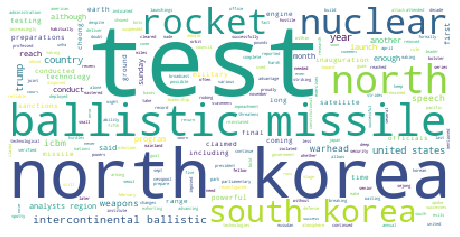

In [9]:
# generate word cloud
def showWordCloud(texts):
    words = ','.join(list(texts))
 
    # show it as wordCloud
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(words)
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(wordcloud.to_image())
    
showWordCloud(docs[4].split())


In [10]:
# extracted from NLP lab exercise
# also same function can be found in scikit-learn website
def display_top_words(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()


# Latent Dirichlet Allocation Analysis

In [11]:
# LDA

# create Document-Word matrix
vectorizer = CountVectorizer(analyzer='word',
                             max_df=0.9,
                             min_df=5,
                             stop_words=text.ENGLISH_STOP_WORDS.union(my_custom_stopwords),
                             lowercase=True)
data_vectorized = vectorizer.fit_transform(docs)


In [12]:
# build a LDA model

lda_model = LatentDirichletAllocation(
    n_components=num_topics,      # Number of topics
    max_iter=5,                   # Max learning iterations
    learning_method='online',   
    learning_offset=50.,
    #n_jobs=-1                    # use all available CPUs
)


In [13]:
last_time = datetime.now()

# this will take some time
lda_output = lda_model.fit_transform(data_vectorized)

past_time = datetime.now() - last_time

# model attributes
print(lda_model)

print()
print('Completed in: {}'.format(past_time))


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=18, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

Completed in: 0:11:32.016259


In [14]:
# Number of documents, Number of topics
lda_output.shape


(50000, 18)

In [15]:
feature_names = vectorizer.get_feature_names()
display_top_words(lda_model, feature_names, num_top_words)


Topic 0:
health medical study migrants disease cancer zika cases patients brain hospital research people doctors risk virus researchers year blood according

Topic 1:
like world change make people work climate time data technology google global future years energy need says facebook different power

Topic 2:
court state federal states immigration department government order justice case legal judge illegal president executive united administration attorney public supreme

Topic 3:
women school black university students children white college student rights sexual community church education parents life people schools young child

Topic 4:
percent health care people year million americans states plan obamacare government workers jobs house rate according years federal american number

Topic 5:
north city south years park space building korea york cuban castro house cuba korean family world home time year father

Topic 6:
border mexico trade united flight mexican wall plane texas pope ai

In [16]:
# Find dominant topics for document

# Styling
def color_norm(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
    
def color_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominantTopic'] = dominant_topic

# Apply Style to first 20 document
df_document_topic2 = df_document_topic.head(20).style.applymap(color_norm).applymap(color_bold)
df_document_topic2


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,dominantTopic
Doc0,0.000000,0.020000,0.350000,0.000000,0.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260000,0.000000,0.050000,0.000000,2
Doc1,0.010000,0.040000,0.030000,0.010000,0.090000,0.030000,0.000000,0.000000,0.130000,0.600000,0.000000,0.000000,0.000000,0.010000,0.020000,0.020000,0.000000,0.000000,9
Doc2,0.010000,0.040000,0.090000,0.090000,0.000000,0.360000,0.000000,0.220000,0.130000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,5
Doc3,0.020000,0.050000,0.000000,0.040000,0.000000,0.230000,0.000000,0.190000,0.270000,0.030000,0.100000,0.010000,0.020000,0.000000,0.030000,0.010000,0.000000,0.000000,8
Doc4,0.000000,0.060000,0.020000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.070000,0.010000,0.000000,0.000000,11
Doc5,0.000000,0.000000,0.000000,0.000000,0.090000,0.580000,0.000000,0.000000,0.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,5
Doc6,0.020000,0.000000,0.020000,0.000000,0.000000,0.010000,0.190000,0.000000,0.000000,0.000000,0.000000,0.590000,0.000000,0.000000,0.170000,0.000000,0.010000,0.000000,11
Doc7,0.430000,0.040000,0.010000,0.000000,0.060000,0.000000,0.000000,0.000000,0.390000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0
Doc8,0.020000,0.000000,0.090000,0.030000,0.000000,0.120000,0.000000,0.220000,0.380000,0.000000,0.090000,0.000000,0.000000,0.000000,0.010000,0.020000,0.010000,0.000000,8
Doc9,0.070000,0.000000,0.000000,0.150000,0.100000,0.180000,0.040000,0.020000,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,8


In [17]:
# Use pyLDAvis to visualise topic model

pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)
panel


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.066721 -0.137703       1        1  13.709965
14     0.089084 -0.134578       2        1  13.154939
16     0.084469 -0.114835       3        1   8.663481
2      0.154706 -0.024952       4        1   7.077913
1      0.092179 -0.095967       5        1   6.872021
11     0.138276  0.076962       6        1   6.531534
9     -0.057681  0.076160       7        1   6.407741
3      0.026491 -0.122584       8        1   5.126061
4      0.162624 -0.039188       9        1   4.857578
12     0.015616  0.103076      10        1   4.335802
13     0.059701 -0.004666      11        1   3.611122
15    -0.100686  0.214169      12        1   3.519366
17    -0.116029 -0.057086      13        1   3.448236
5     -0.179917  0.058176      14        1   3.176992
7     -0.251843 -0.106272      15        1   2.955523
10    -0.162623 -0.045762      16        1   2.564490
0      0.065842  0.100078      17        1   2.533717
6      0.046512  0.254974      18        1   1.453522, topic_info=                Term           Freq          Total Category  logprob  loglift
47689          trump  149268.000000  149268.000000  Default  30.0000  30.0000
34963         police   30499.000000   30499.000000  Default  29.0000  29.0000
31267           news   35105.000000   35105.000000  Default  28.0000  28.0000
47947        twitter   25483.000000   25483.000000  Default  27.0000  27.0000
9046         company   16545.000000   16545.000000  Default  26.0000  26.0000
...              ...            ...            ...      ...      ...      ...
1481        american    1394.516474   25556.391428  Topic18  -5.0158   1.3228
23706  international    1134.192022    9500.749151  Topic18  -5.2224   2.1057
10298        country    1186.138066   28752.709827  Topic18  -5.1776   1.0432
41014       security    1135.366962   19591.894704  Topic18  -5.2214   1.3830
10297      countries    1025.594842    9380.638485  Topic18  -5.3230   2.0178

[1426 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
28        10  0.997882       abbas
82         3  0.998846      abedin
146        2  0.069083    abortion
146        4  0.002878    abortion
146        8  0.927577    abortion
...      ...       ...         ...
51588     17  0.014910       young
51744     18  0.998018       zetas
51764     12  0.002808        zika
51764     17  0.997003        zika
51830      5  0.998995  zuckerberg

[6126 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 15, 17, 3, 2, 12, 10, 4, 5, 13, 14, 16, 18, 6, 8, 11, 1, 7])

In [18]:
# Find good model performance for LDA
# using (Perplexity and log-likelihood)

if not SKIP:
    
    last_time = datetime.now()

    kmin = 18
    kmax = 22

    topic_models = []

    # try each value of k
    for k in range(kmin, kmax+1):
        print("Applying LDA for k=%d ..." % k )
        model = LatentDirichletAllocation(
             n_components=k,               # Number of topics
             max_iter=5,                   # Max learning iterations
             learning_method='online',   
             learning_offset=50.,
             #n_jobs=-1
        )

        output = model.fit_transform(data_vectorized) 
        log_likelihood = lda_model.score(data_vectorized)
        perplexity = model.perplexity(data_vectorized)
        topic_models.append((k, model, output, log_likelihood, perplexity))

    for model in topic_models:
        print('topics : % 2d, Log Likelihood : % 5.2f   Perplexity : %5.2f' %(model[0], model[3], model[4]))
        
    past_time = datetime.now() - last_time
    print()
    print('Completed in: {}'.format(past_time))


Applying LDA for k=18 ...
Applying LDA for k=19 ...
Applying LDA for k=20 ...
Applying LDA for k=21 ...
Applying LDA for k=22 ...
topics :  18, Log Likelihood : -122287897.59   Perplexity : 4664.70
topics :  19, Log Likelihood : -122287897.59   Perplexity : 4640.11
topics :  20, Log Likelihood : -122287897.59   Perplexity : 4706.00
topics :  21, Log Likelihood : -122287897.59   Perplexity : 4658.03
topics :  22, Log Likelihood : -122287897.59   Perplexity : 4660.64

Completed in: 1:06:32.812967


# Non-Negative Matrix Factorization (NMF)

In [19]:
# just to ensure that the docs hasn't been changed
print(docs[4])


seoul south korea north korea leader sunday country making final preparations conduct first test intercontinental ballistic missile bold statement less month inauguration donald trump although north korea conducted five nuclear tests last decade ballistic missile tests alone although habitually threatens attack united states nuclear weapons country never intercontinental ballistic missile icbm annual year speech broadcast north kctv sunday spoke proudly strides country made nuclear weapons ballistic missile programs north korea would continue bolster weapons programs long united states remained hostile continued joint military exercises south korea reached final stage preparations intercontinental ballistic rocket said analysts region might conduct another weapons test coming months taking advantage leadership changes united states south korea trump sworn south korea president park whose powers suspended parliamentary impeachment waiting constitutional court rule whether formally remov

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                   min_df=2,
                                   stop_words=text.ENGLISH_STOP_WORDS.union(my_custom_stopwords),
                                   max_features=1000)

tfidf = tfidf_vectorizer.fit_transform(docs)


In [21]:
nmf_model = NMF(n_components=num_topics, 
                alpha=.1,
                l1_ratio=.5,
                init="nndsvd")


In [22]:
last_time = datetime.now()

# this will take some time
nmf_output = nmf_model.fit_transform(tfidf)

past_time = datetime.now() - last_time

# model attributes
print(nmf_model)  

print()
print('Completed in: {}'.format(past_time))


NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=200,
    n_components=18, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

Completed in: 0:00:50.391268


In [23]:
nmf_output.shape


(50000, 18)

In [24]:
print("\nTopics in NMF mode:")
feature_names = tfidf_vectorizer.get_feature_names()
display_top_words(nmf_model, feature_names, num_top_words)



Topics in NMF mode:
Topic 0:
people like think know going time life says really want years family make work things good world didn right told

Topic 1:
trump president campaign republican presidential election nominee pence going america rally media twitter white washington supporters speech think debate comments

Topic 2:
police officers officer shooting shot city arrested black killed suspect authorities attack video incident told department according enforcement county reported

Topic 3:
european migrants immigration europe britain united union country border minister states government germany party countries prime british refugees world immigrants

Topic 4:
sanders hillary democratic party campaign presidential bernie candidate election voters state republican nominee vote democrats convention primary supporters candidates emails

Topic 5:
isis islamic syria attack state military syrian forces iraq attacks terrorist group killed city turkey security muslim terror government iran



In [25]:
# column names
topicnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominantTopic'] = dominant_topic

# Apply Style to first 20 document
df_document_topic2 = df_document_topic.head(20).style.applymap(color_norm).applymap(color_bold)
df_document_topic2


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,dominantTopic
Doc0,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.060000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,11
Doc1,0.020000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000,0.000000,0.000000,2
Doc2,0.030000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0
Doc3,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.020000,0.000000,0.000000,0
Doc4,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
Doc5,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Doc6,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
Doc7,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0
Doc8,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0
Doc9,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0


In [26]:
def model_topics(model, model_name, vect, num_top_word):
    model_df = pd.DataFrame(columns=['Topic', model_name])
    
    topicList = []
    
    for _, topic in enumerate(model.components_):
        topicList.append(" ".join([vect.get_feature_names()[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

    for idx, model in enumerate(topicList):
        model_df.loc[idx] = [idx] + [model]
        
    return model_df
        

In [27]:
pd.set_option('display.max_colwidth', None)


In [28]:
lda_model_df = model_topics(lda_model, 'LDA', vectorizer, num_top_words)
lda_model_df


,Topic,LDA
0,0,health medical study migrants disease cancer zika cases patients brain hospital research people doctors risk virus researchers year blood according
1,1,like world change make people work climate time data technology google global future years energy need says facebook different power
2,2,court state federal states immigration department government order justice case legal judge illegal president executive united administration attorney public supreme
3,3,women school black university students children white college student rights sexual community church education parents life people schools young child
4,4,percent health care people year million americans states plan obamacare government workers jobs house rate according years federal american number
5,5,north city south years park space building korea york cuban castro house cuba korean family world home time year father
6,6,border mexico trade united flight mexican wall plane texas pope airport states cartel india airlines breitbart american canada agents francis
7,7,film star movie music series year hollywood best actor song video actress singer awards season angeles night fans band stars
8,8,people like know going think time says want really didn good right things make years told life thing little look
9,9,police officers told according officer city authorities death killed video shooting shot reported people arrested incident prison family investigation violence


In [29]:
nmf_model_df = model_topics(nmf_model, 'NMF', tfidf_vectorizer, num_top_words)
nmf_model_df


,Topic,NMF
0,0,people like think know going time life says really want years family make work things good world didn right told
1,1,trump president campaign republican presidential election nominee pence going america rally media twitter white washington supporters speech think debate comments
2,2,police officers officer shooting shot city arrested black killed suspect authorities attack video incident told department according enforcement county reported
3,3,european migrants immigration europe britain united union country border minister states government germany party countries prime british refugees world immigrants
4,4,sanders hillary democratic party campaign presidential bernie candidate election voters state republican nominee vote democrats convention primary supporters candidates emails
5,5,isis islamic syria attack state military syrian forces iraq attacks terrorist group killed city turkey security muslim terror government iran
6,6,company million business companies billion apple year market google employees according industry technology insider facebook money tech price firm financial
7,7,breitbart news twitter media texas facebook follow daily bannon milo live conservative radio editor host reported social political reporter amendment
8,8,russia russian comey intelligence investigation putin committee information officials director flynn emails house security department president election email james sessions
9,9,obama president white barack administration house iran united office american israel states bush congress americans america press presidency policy washington


##### Acknowledgement:
- The script below, mostly are adapted from Derek Greene, University College Dubin
- Original source: https://github.com/derekgreene/topic-model-tutorial



In [30]:
# Apply NMF for each of these values using a for-loop
topic_models = []

kmin = 16
kmax = 32

last_time = datetime.now()

# try each value of k
for k in range(kmin, kmax+1):
    print("Applying NMF for k=%d ..." % k )
    model = NMF( init="nndsvd", n_components=k, alpha=.1, l1_ratio=.5 )   
    
    W = model.fit_transform(tfidf)
    H = model.components_  
    
    # store for later
    # tfidf never change, no need to save multiple time..
    topic_models.append((k,W,H)) 
    
past_time = datetime.now() - last_time
print()
print('Completed in: {}'.format(past_time))


Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...

Completed in: 0:15:12.254031


In [31]:
class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

In [32]:
# the following script is going to take a long time
import gensim

docgen = TokenGenerator(docs.tolist(), text.ENGLISH_STOP_WORDS.union(my_custom_stopwords))

# the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=300, min_count=20, sg=1)


Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [34]:
print("Model has %d terms" % len(w2v_model.wv.vocab))


Model has 31731 terms


In [35]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


In [36]:
def get_descriptor(terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms


In [37]:
terms = feature_names

k_values = []
coherences = []

last_time = datetime.now()

for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    
past_time = datetime.now() - last_time
print()
print('Completed in: {}'.format(past_time))


K=16: Coherence=0.3278
K=17: Coherence=0.3351
K=18: Coherence=0.3331
K=19: Coherence=0.3354
K=20: Coherence=0.3316
K=21: Coherence=0.3317
K=22: Coherence=0.3315
K=23: Coherence=0.3254
K=24: Coherence=0.3239
K=25: Coherence=0.3217
K=26: Coherence=0.3237
K=27: Coherence=0.3214
K=28: Coherence=0.3192
K=29: Coherence=0.3191
K=30: Coherence=0.3207
K=31: Coherence=0.3216
K=32: Coherence=0.3211

Completed in: 0:00:00.666734


In [38]:
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})


([<matplotlib.axis.XTick at 0x1dedf427488>,
 <a list of 17 Text xticklabel objects>)

Text(0.5, 0, 'Number of Topics')

Text(0, 0.5, 'Mean Coherence')

Text(19, 0.3353929491898818, 'k=19')

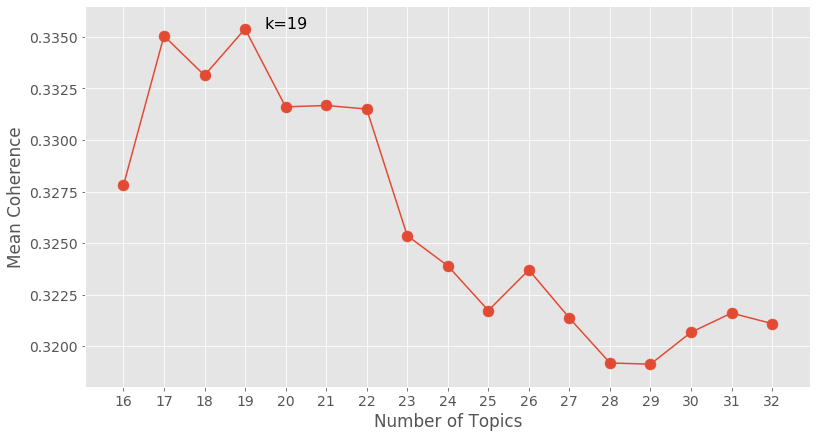

In [39]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)

# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()


In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

#### Please answer the two questions in the next cell:

Question 1: Was the outcome of the topic modelling satisfactory. Why or why not ?


Question 2: Which approach (LDA or NFM) works better? Why?